In [69]:
import requests
import json
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import csv
import math
import descartes
import geoplot
import plotly.figure_factory as ff

In [3]:
api_key = 'b75abaaeb7e41a94fca6dce80b3eeac5289e46a9'

In [19]:
resp = requests.get(f'http://api.census.gov/data/2018/pep/population?get=POP&for=county:*&key={api_key}')
resp.status_code

200

In [28]:
poplist = resp.json()
pop_df = pd.DataFrame(poplist[1:], columns = poplist[0])
pop_df['FIPS'] = pop_df.state + pop_df.county
pop_df.POP = pop_df.POP.astype('int')

In [48]:
pop_df.head()

,POP,state,county,FIPS
0,55601,01,001,01001
1,218022,01,003,01003
2,24881,01,005,01005
3,22400,01,007,01007
4,57840,01,009,01009


In [49]:
pop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 4 columns):
POP       3220 non-null int64
state     3220 non-null object
county    3220 non-null object
FIPS      3220 non-null object
dtypes: int64(1), object(3)
memory usage: 100.8+ KB


In [37]:
rural_lookup = pd.read_excel('County_Rural_Lookup.xlsx', skiprows = 3)

In [40]:
rural_lookup.drop(rural_lookup.tail(6).index,inplace=True)

In [43]:
del rural_lookup['Note']
del rural_lookup['Unnamed: 8']

In [45]:
rural_lookup.columns = ['FIPS', 'State', 'County_State', 'Total_pop', 'Urban_pop', 'Rural_pop', 'Percent_Rural']

In [47]:
rural_lookup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3142 entries, 0 to 3141
Data columns (total 7 columns):
FIPS             3142 non-null object
State            3142 non-null object
County_State     3142 non-null object
Total_pop        3142 non-null float64
Urban_pop        3142 non-null float64
Rural_pop        3142 non-null float64
Percent_Rural    3142 non-null float64
dtypes: float64(4), object(3)
memory usage: 196.4+ KB


In [50]:
rural_lookup.head()

,FIPS,State,County_State,Total_pop,Urban_pop,Rural_pop,Percent_Rural
0,01001,AL,"Autauga County, Alabama",54571.0,31650.0,22921.0,42.002162
1,01003,AL,"Baldwin County, Alabama",182265.0,105205.0,77060.0,42.279099
2,01005,AL,"Barbour County, Alabama",27457.0,8844.0,18613.0,67.789635
3,01007,AL,"Bibb County, Alabama",22915.0,7252.0,15663.0,68.352607
4,01009,AL,"Blount County, Alabama",57322.0,5760.0,51562.0,89.951502


In [53]:
pop_df1 = pop_df.merge(rural_lookup, on = 'FIPS', how = 'inner')
pop_df1.head()

,POP,state,county,FIPS,State,County_State,Total_pop,Urban_pop,Rural_pop,Percent_Rural
0,55601,01,001,01001,AL,"Autauga County, Alabama",54571.0,31650.0,22921.0,42.002162
1,218022,01,003,01003,AL,"Baldwin County, Alabama",182265.0,105205.0,77060.0,42.279099
2,24881,01,005,01005,AL,"Barbour County, Alabama",27457.0,8844.0,18613.0,67.789635
3,22400,01,007,01007,AL,"Bibb County, Alabama",22915.0,7252.0,15663.0,68.352607
4,57840,01,009,01009,AL,"Blount County, Alabama",57322.0,5760.0,51562.0,89.951502


In [55]:
pop_df1.describe()

,POP,Total_pop,Urban_pop,Rural_pop,Percent_Rural
count,3.142000e+03,3.142000e+03,3.142000e+03,3142.000000,3142.000000
mean,1.041271e+05,9.826220e+04,7.932755e+04,18934.482177,58.668348
std,3.334863e+05,3.129477e+05,3.089908e+05,16666.280976,31.501511
min,8.800000e+01,8.200000e+01,0.000000e+00,0.000000,0.000000
25%,1.092650e+04,1.111450e+04,2.566250e+03,7056.500000,33.379442
50%,2.575850e+04,2.587200e+04,9.179500e+03,14240.000000,59.537911
75%,6.782050e+04,6.678000e+04,3.764700e+04,25553.500000,88.293167
max,1.010552e+07,9.818605e+06,9.759181e+06,146856.000000,100.000000


In [59]:
def rural_marker(percent):
    marker = None
    if percent <= 30:
        marker = 'Urban'
    elif percent <= 70:
        marker = 'Mix/Suburban'
    else:
        marker = 'Rural'
    return marker

In [60]:
pop_df1['pop_category'] = pop_df1.Percent_Rural.map(lambda x: rural_marker(x))

In [61]:
pop_df1.head()

,POP,state,county,FIPS,State,County_State,Total_pop,Urban_pop,Rural_pop,Percent_Rural,pop_category
0,55601,01,001,01001,AL,"Autauga County, Alabama",54571.0,31650.0,22921.0,42.002162,Mix/Suburban
1,218022,01,003,01003,AL,"Baldwin County, Alabama",182265.0,105205.0,77060.0,42.279099,Mix/Suburban
2,24881,01,005,01005,AL,"Barbour County, Alabama",27457.0,8844.0,18613.0,67.789635,Mix/Suburban
3,22400,01,007,01007,AL,"Bibb County, Alabama",22915.0,7252.0,15663.0,68.352607,Mix/Suburban
4,57840,01,009,01009,AL,"Blount County, Alabama",57322.0,5760.0,51562.0,89.951502,Rural


In [68]:
pop_df1.pop_category.value_counts()

Mix/Suburban    1241
Rural           1213
Urban            688
Name: pop_category, dtype: int64

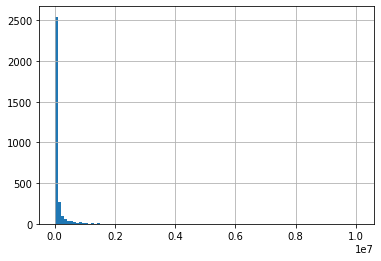

In [71]:
pop_df1.POP.hist(bins = 100)